# Unsupervised Anomaly Detection on Security Logs using <u>Levenshtein Similarity Score</u>
This is a continuation of the prior research. In this notebook, we are leveraging the Isolation Forest algorithm to perform unsupervised training of an anomaly detection model.  HOWEVER...we are trying this using Levenshtein similarity score INSTEAD OF using text vector embeddings as the input. I expect that this approach will be much less accurate...Levenshtein score is a scalar value that is the minimum number of distinct edits to make two text passages the same, versus a 384-dimension vector embedding output by a language-interpreting LLM that is trying to capture the meaning of the text. This is a no-AI approach to this problem, but it's worth investigating.  Will it work?  Will it come close to the known actual 950/50 split of good/bad log entries?  Let us see...

In [1]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas
#! pip install matplotlib
#! pip install sklearn
#! pip install levenshtein

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import pairwise_distances
import Levenshtein as lev

In [3]:
# Levenshtein calculates the minimum number of insertions, deletions, and substitutions required to change 
# one text sequence into the other with custom costs for insertion, deletion and substitution
# This gives us a "rule-based" means to score text dis-similarity, versus using an LLM that allows us to 
# compare and score the meaning of the text
# Example...should return a score of 2:
lev.distance("lewenstein", "levenshtein")

2

In [6]:
# We'll use the fabricated mixed proxy logs with known 950 benign log entries and 50 malicious log entries 
# Our goal is to see if we can get them accurately classified into that 950 benign + 50 malicious
# Read the log data into a dataframe, and drop the columns we don't need for this exercise, and 
# extract the return code to use in validating the eventual output
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df['return_code'] = df['Log Entry'].str.split().str[3]
df.sample(3)

,ID,Log Entry,return_code
736,737,GET http://cloudstorage.com/authenticate HTTP/...,200
582,583,"GET http://cloudstorage.com/login HTTP/1.1"" 20...",200
546,547,GET http://update.software.com/version.xml HTT...,200


In [7]:
# Let's confirm that we have 950 benign (rc = 200) and 50 malicious (rc != 200)
df['return_code'].value_counts()

return_code
200    950
403     18
500     11
404     11
400     10
Name: count, dtype: int64

In [20]:
# Compute the pairwise distance matrix.  Since we don't have vector embeddings to work with, we have to 
# have some way to calculate a similarity score between text passages.  Normally, this work would be done
# by the vector datastore on-the-fly during an HNSW vector search...since we don't have that, we have to 
# pre-calculate this matrix ahead of time.

# This creates a matrix of every row x every row and the Levenshtein distance between each row's text, 
# related back to the original dataframe by the ID. The distance matrix looks something like this: 
#       ABC   BCD   DEF
# ABC    0     2     6
# BCD    2     0     4
# DEF    6     4     0
# For instance, the distance between ABC and BCD in edits is 1 delete and 1 insertion, for a score of 2.
# For Levenshtein distance, lower is better.

distance_matrix = pairwise_distances(df['Log Entry'].values.reshape(-1, 1), 
                                     metric=lambda x, y: lev.distance(x[0], y[0]))
distance_matrix.shape # Check the shape of the matrix

(1000, 1000)

In [21]:
# Define a model object with the Isolation Forest algorithm
# Let's favor a large number of samples and let the algorithm figure out the contamination ratio
model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Fit the data to the model
model.fit(distance_matrix)

# Display parameter values that were used
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [22]:
# Add a column to the DF for raw scores from the model's decision_function
df['raw_score'] = model.decision_function(distance_matrix)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score'] = model.predict(distance_matrix)

In [23]:
# Display the data with the score columns added
df.sample(3)

,ID,Log Entry,return_code,raw_score,anomaly_score
234,235,"GET http://update.software.com/version.xml HTTP/1.1"" 200 966133 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",200,0.046171,1
298,299,"GET http://cloudstorage.com/files HTTP/1.1"" 200 45752 ""http://cloudstorage.com/files"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0",200,0.038845,1
362,363,"GET http://www.example.com/ HTTP/1.1"" 200 680119 ""http://www.example.com/"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",200,0.044471,1


In [24]:
# Display just the anomalies
df[df['anomaly_score']==-1].sample(3)

,ID,Log Entry,return_code,raw_score,anomaly_score
981,982,"GET http://www.example.com/../../etc/passwd HTTP/1.1"" 400 853084 ""http://www.example.com/../../etc/passwd"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36",400,-0.013329,-1
646,647,"GET http://update.software.com/version.xml HTTP/1.1"" 200 721593 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0",200,-0.000461,-1
973,974,"GET http://www.example.com/search?q=<script>alert('xss')</script> HTTP/1.1"" 400 811308 ""http://www.example.com/search?q=<script>alert('xss')</script>"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36",400,-0.127352,-1


In [25]:
# The outliers have anomaly_score = -1
# This is pretty darned good, given that we know the real split is 950/50
df['anomaly_score'].value_counts()

anomaly_score
 1    930
-1     70
Name: count, dtype: int64

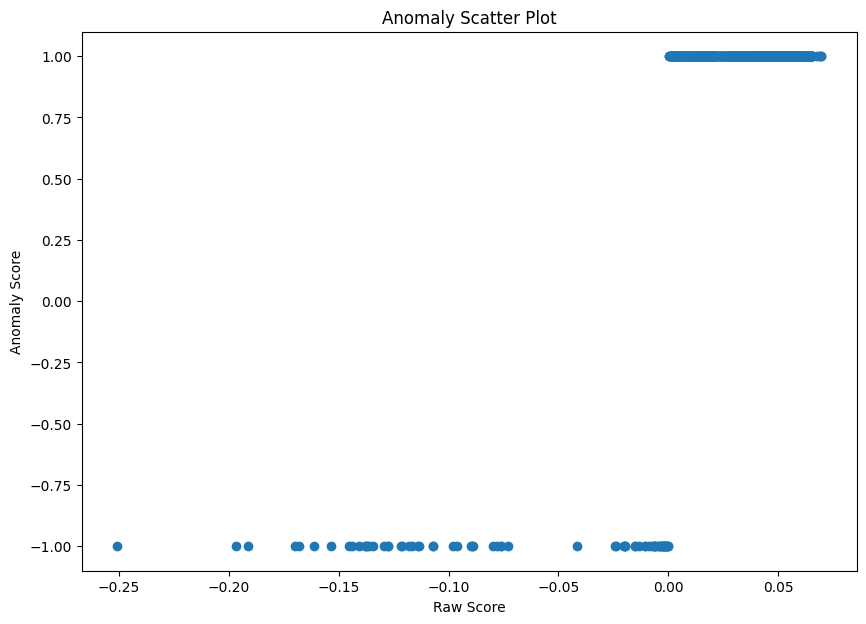

In [26]:
# Scatter plot of the anomaly_score results...it's what we'd expect to see given the counts above
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df.raw_score, df.anomaly_score)
plt.title('Anomaly Scatter Plot')
plt.xlabel('Raw Score')
plt.ylabel('Anomaly Score')
plt.show()

In [27]:
# Let's examine whether the 70-ish anomalies include all of the 50 known malicious log entries
print("GOOD:  Count of entries flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))
print("FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("GOOD: Count of entries not flagged anomaly and return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))


GOOD:  Count of entries flagged anomaly and return_code not 200: 44
FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: 26
FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: 6
GOOD: Count of entries not flagged anomaly and return_code is 200: 924


In [28]:
# Let's examine the "false negatives", since those would be the bigger concern...rows flagged as not an 
# anomaly but have return_code that's not 200
pd.set_option('max_colwidth', None) # show full width of showing cols
df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score', 'Log Entry']]

# These may not have been anomalies (not unusual log entries, compared to the bulk of logs), but were 
# actually malicious log entries that were blocked/failed

,return_code,anomaly_score,Log Entry
959,404,1,"GET http://www.example.com/admin HTTP/1.1"" 404 997522 ""http://www.example.com/admin"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
960,403,1,"GET http://www.example.com/admin HTTP/1.1"" 403 98619 ""http://www.example.com/admin"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
963,404,1,"GET http://www.example.com/admin HTTP/1.1"" 404 603181 ""http://www.example.com/admin"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
995,400,1,"GET http://www.example.com/admin HTTP/1.1"" 400 809282 ""http://www.example.com/admin"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
996,403,1,"GET http://www.example.com/admin HTTP/1.1"" 403 19118 ""http://www.example.com/admin"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
998,403,1,"GET http://www.example.com/admin HTTP/1.1"" 403 171906 ""http://www.example.com/admin"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"


In [29]:
# Let's examine the "false positives"...rows flagged as anomaly but have return_code 200
pd.set_option('max_colwidth', None) # show full width of showing cols
df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score', 'Log Entry']]

# These may have truly anomalies (unusual log entries compared to the bulk of logs), but just were 
# not actually malicious log entries

,return_code,anomaly_score,Log Entry
92,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 90366 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
122,200,-1,"GET http://update.software.com/version.xml HTTP/1.1"" 200 923237 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
132,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 49135 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
174,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 566608 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
179,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 1022325 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
215,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 102229 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
220,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 42671 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
240,200,-1,"GET http://update.software.com/version.xml HTTP/1.1"" 200 4178 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
285,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 862768 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
289,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 502542 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"


Our unsupervised ML model, trained using a very simple distance metric that was merely the number of edits to make two text passages the same, did surprisingly well.  It flagged 70 log entries as anomalies, with 930 seen as typical. It missed 6 malicious logs that were not necessarily anomalies (false negatives), while flagging 26 benign logs they may have been anomalies that weren't malicous. (Keeping in mind that we're using fake proxy log data for this exercise...your mileage may vary). We know the real answer from the fabricated test log entry data is 950 benign and 50 malicious.  This may be worth testing on real data and/or larger data sets, as it might be at least useable as a coarse-grained pre-filter. 